# Lecture 5: Bayesian Formalism Part I
AM207: Verena Kaynig-Fittkau,and Pavlos Protopapas, Harvard University


In [7]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
sns.set_style('white')
sns.set_context('talk')

### Stratification Example:

For a  one-dimensional application we take $ f(x) = \frac{x}{(x^2+1)}$ and integrate from $[0,10]$.
We break $[0,10]$ into $M$ strata and for each stratum, take $N/M$ samples
with uniform probability distribution. Compute the average within each 
stratum, and then calculate the overall average. 

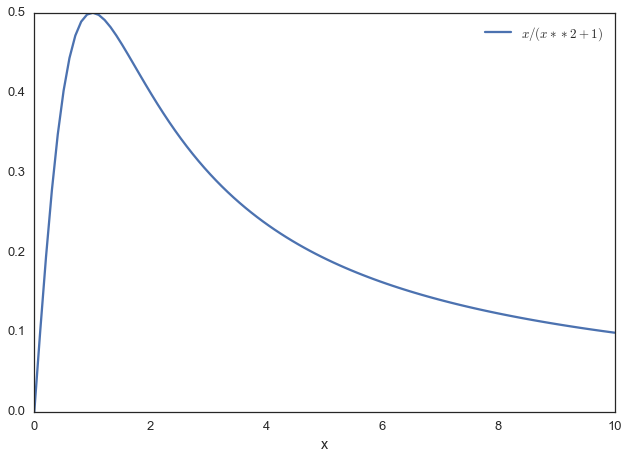

In [3]:
# Function definitions
Y = lambda x: x/(x**2+1.0);
intY = lambda x: np.log(x**2 + 1.0)/2.0;

## Ploting the original functions 
x = np.linspace(0,10,100)
plt.plot(x, Y(x), label=u'$x/(x**2+1)$')
plt.xlabel('x')
plt.legend()
plt.show()

C:\Users\vkaynig\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


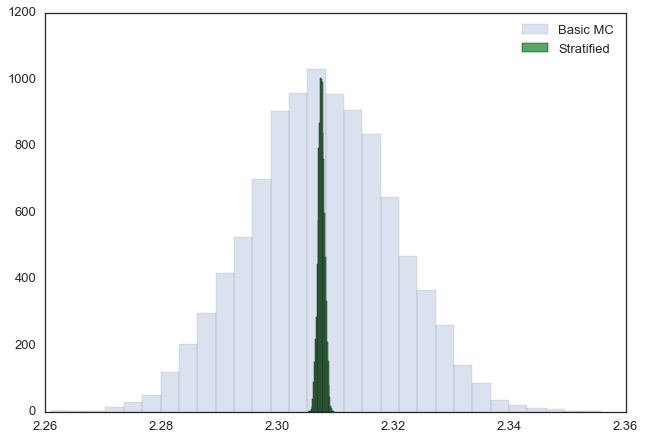

std dev of vanilla monte carlo:  0.0123537872101
std dev with stratification:  0.000575078853068
mean of vanilla monte carlo:  2.30758617119
mean with stratification:  2.30757105611


In [4]:
# number of samples
N = 10000
# number of strata
M = 100.0

# bounds of our integral
xmin = 0
xmax = 10

# analytic solution 
Ic = intY(xmax)-intY(xmin)

# I_monte_carlo
Imc = np.zeros(N)
# I_stratified
Is = np.zeros(N)

for k in np.arange(0,N):
    # range of our uniform distribution
    # whole range for vanilla
    Umin = 0
    Umax = 10
    
    # First lets do vanilla Monte Carlo.
    U = np.random.uniform(low=Umin, high=Umax, size=N)
    Imc[k] = (Umax-Umin)* np.mean(Y(U))

    # Now stratified with M regions
    step = (Umax-Umin )/M
    Umin = 0 
    Umax = step
    # Ii sums up our results
    Ii = 0
    
    # loop over all strata
    for region in np.arange(0,M):
        # sample for this stratum
        x = np.random.uniform(low=Umin, high=Umax, size=1.0*N/M);
        # update Ii with the additional stratum data
        Ii = Ii+(Umax-Umin)* np.mean(Y(x))
        # update bounds for next stratum
        Umin = Umin + step
        Umax = Umin + step
        
    #save stratified result from this iteration
    Is[k] = Ii

# visualize the improvement
plt.hist(Imc,30, alpha=0.2, label=u'Basic MC');
plt.hist(Is,30, label = u'Stratified');
plt.legend()
plt.show()

print "std dev of vanilla monte carlo: ", np.std(Imc)
print "std dev with stratification: ", np.std(Is)

print "mean of vanilla monte carlo: ", np.mean(Imc)
print "mean with stratification: ", np.mean(Is)

### Example: Linear regression of one dimensional straight line
Again, the goal  is to fit a straight line. 

$$ y = ax+b+\epsilon$$

where $\epsilon \sim N(0, \sigma)$
and predict $y$ at various $x$'s. 

Let ${\bf x} =(x_1, x_2, \ldots, x_n)$  and
$ {\bf y} =(y_1, y_2, \ldots, y_n)$ are the actual data. 

Using Bayesian formalism, we want to estimate the posteriors of the parameter
$\theta =a$ assuming $b=0$. 

We use  priors $a \sim N(0, \sigma_a)$.

 
The implementation below estimates the posterior using Bayes rule  and also samples 
directly from the product of the likelihood (same as the one in the MLE section above) and prior using the rejection method. 



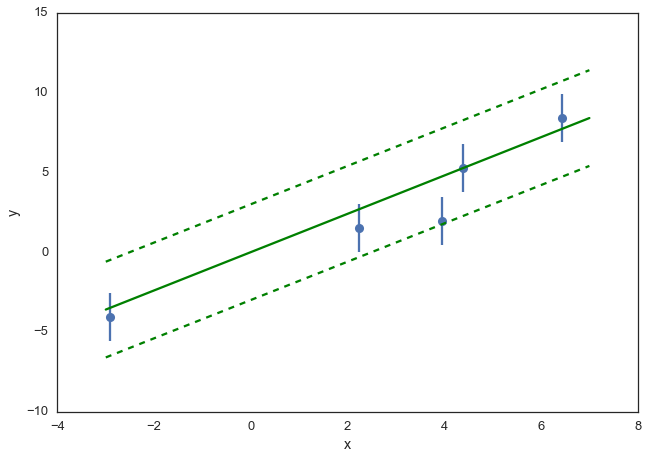

In [8]:
## GENERATE SYNTHETIC DATA
n=5

a = 1.2 # slope
b = 0 # intersection 

sigma_e = 1.5 # std deviation of the error 

x = np.random.uniform(low=-3, high=7, size=n) 
y = a*x+ b + stats.norm.rvs(loc=0, scale=sigma_e, size=len(x))

plt.errorbar(x,y, yerr=sigma_e, fmt='o')
plt.xlabel('x')
plt.ylabel('y')

xr = np.linspace(-3, 7, 100) 
plt.plot(xr, a*xr, '-', c='g')
plt.plot(xr, a*xr + 2*sigma_e, '--', c='g')
plt.plot(xr, a*xr - 2*sigma_e, '--', c='g')

Using priors with mean 0 and $\sigma_a^2=4$. $a \sim N(0, \sigma_a)$

1.2682087367 -0.0


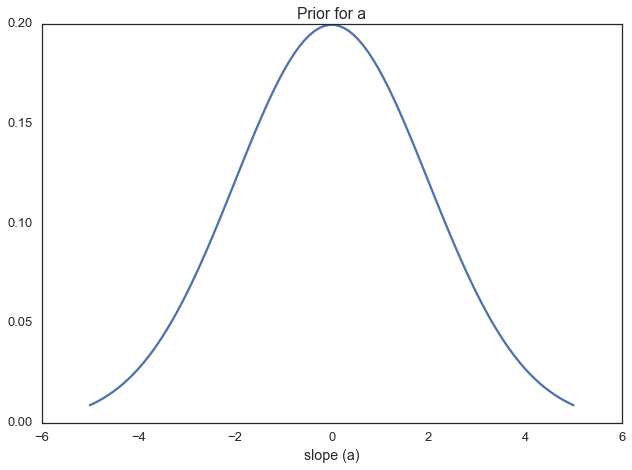

In [9]:
## ANALYTIC SOLUTION TO THE MAXIMUM LIKELIHOOD 
a_ml = (n*np.sum(x*y)-np.sum(x)*np.sum(y))/(n*np.sum(x**2)-(np.sum(x))**2)
b_ml = (1/n)*(np.sum(y)-a*np.sum(x))
print a_ml, b_ml

# ======================================
## PLOT THE PDF OF THE PRIOR
# ======================================
I = np.eye(2)

## PRIOR 
sigma_a = 2   # WIDTH OF THE PRIOR
prior = lambda a: stats.norm.pdf(a, loc=0, scale=sigma_a)

x_plot = np.linspace(-5,5, 100)

plt.plot(x_plot, prior(x_plot))
plt.xlabel('slope (a)')
plt.title('Prior for a')

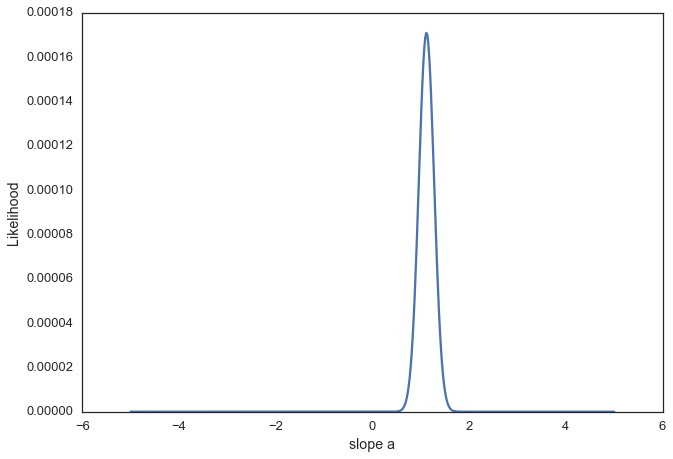

In [10]:
## PLOT THE PDF OF THE LIKELIHOOD
a_plot = np.linspace(-5,5, N)

# be careful here with the np.prod. This can become unstable pretty fast!
likelihood_i = lambda x_i, y_i, a: stats.norm.pdf(y_i, loc=a*x_i, scale=sigma_e)
likelihood = lambda x, y, a: np.prod([likelihood_i(x_i, y_i, a) for x_i, y_i in zip(x,y)])

plt.plot(a_plot, [likelihood(x,y,a) for a in a_plot], label='with data')
plt.xlabel('slope a')
plt.ylabel('Likelihood')

Let's plot the posterior

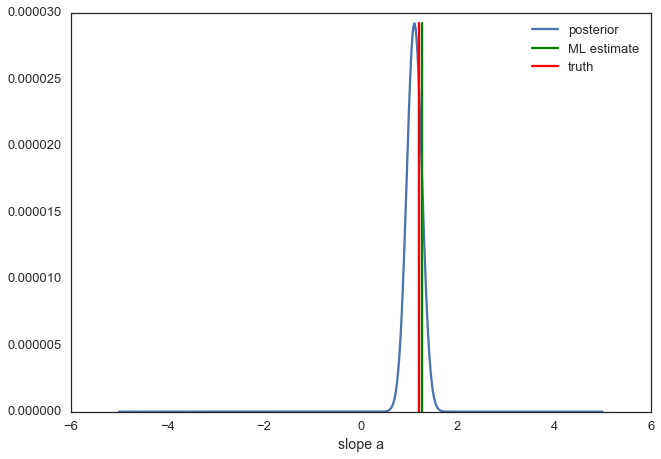

In [11]:
posterior = lambda a: likelihood(x,y,a) * prior(a)

posterior_values = [posterior(a) for a in a_plot]

plt.plot(a_plot, posterior_values, label='posterior')
plt.plot([a_ml,a_ml],[0,np.max(posterior_values)], 'g', label='ML estimate')
plt.plot([1.2,1.2],[0,np.max(posterior_values)], 'r', label='truth')
plt.xlabel('slope a')
plt.legend()

2018


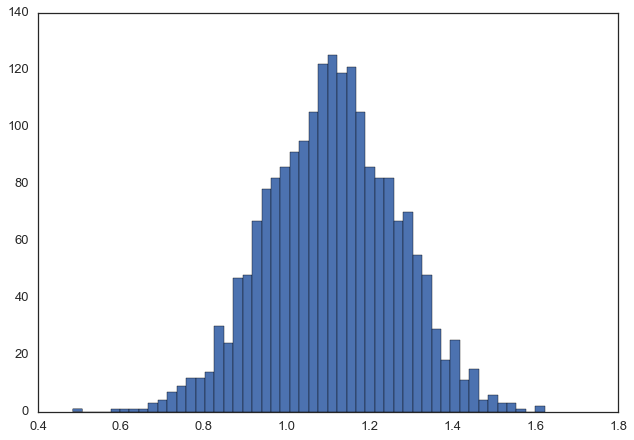

In [12]:
# Sample from the posterior

a_min = 0
a_max = 2
y_min = 0
y_max = np.max(posterior_values)

N = 10000
a_samples = np.random.uniform(low=a_min, high=a_max, size=N)
reject_condition = np.random.uniform(low=y_min, high=y_max, size=N)
a_posterior = [posterior(a) for a in a_samples]
a_samples = a_samples[reject_condition <  a_posterior]

print len(a_samples)
a_hist = plt.hist(a_samples, bins=50)
plt.show()

In [13]:
a_map_index = np.argmax(a_hist[0])
a_hist_bin_middle = 0.5*a_hist[1][:-1] + 0.5*a_hist[1][1:]
a_map = a_hist_bin_middle[a_map_index] 
a_exp = np.sum(a_hist_bin_middle*a_hist[0]/np.double(len(a_samples)))
print "MAP for a: ", a_map
print "Exp for a: ", a_exp
print "ML for a: ", a_ml

MAP for a:  1.11014378854
Exp for a:  1.10969239807
ML for a:  1.2682087367


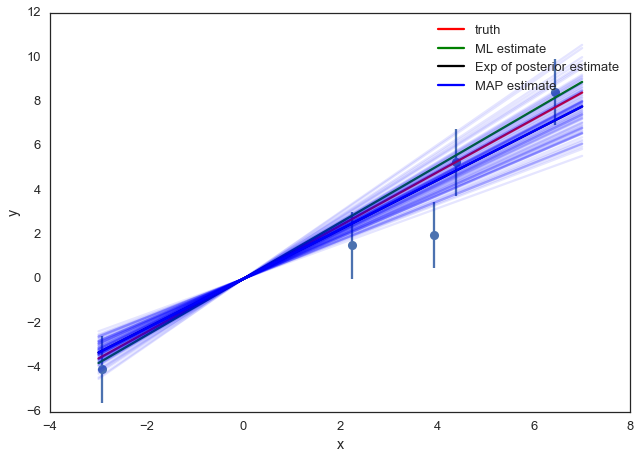

In [14]:
plt.errorbar(x,y, yerr=sigma_e, fmt='o')
plt.xlabel('x')
plt.ylabel('y')

xr = np.linspace(-3, 7, 100) 
plt.plot(xr, 1.2*xr, '-', c='r',label='truth')
plt.plot(xr, a_ml*xr, c='g', label='ML estimate')
plt.plot(xr, a_exp*xr, c='k', label='Exp of posterior estimate')
plt.plot(xr, a_map*xr, c='b', label='MAP estimate')
for i in range(100):
    a = a_samples[i]
    plt.plot(xr, a*xr, c='b', alpha=0.1)
plt.legend()

# Priors loose their powers as N increases 
Our prior looses it's powers as we get more and more data. The prior is our previous belief, and eventually enough new information will overwelm our previous belief. The derease of the influence of the prior by enough data is also good news: if our prior is significantly wrong, then the data will correct that and eventually we will be presented with the correct posterior.

Lets demonstrate this with an example. We look at the case where the likelihood is a Bernoulli and we choose two Beta priors, one a flat prior and the other biased  towards 0 (Beta is  the conjugate prior for the Bernoulli). We look at the parameter $\theta$ of the two posteriors. As the sample size increases, the posteriors converge.

The Beta is conjugate prior to Bernouli and the hypermarameters (parameters of the distribution function) are given 

$$ Beta\left(a+\sum_i x_i ,b+n-\sum_i x_i\right)=Beta(a,b) \, \, \rm{Bernoulli(x|\theta)}$$



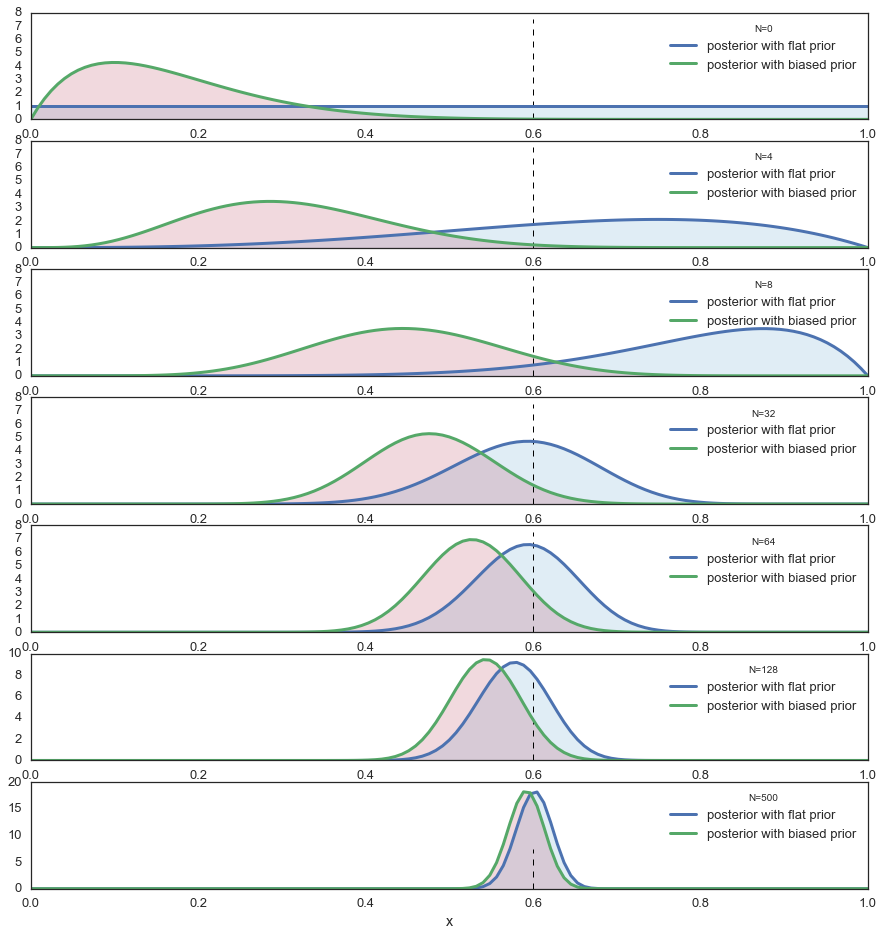

In [5]:
plt.figure(figsize=( 15, 18))

# success probability for our Bernoulli
p = 0.6

# two priors, the first one is flat
beta1_params = np.array( [1.,1.] )  # FLAT 
beta2_params = np.array( [2,10] )
beta = stats.beta 

x = np.linspace(0.00, 1, 125)

#sample from the likelihood
data = stats.bernoulli.rvs(p,size=500)   #LIKELIHOOD

# vary the amount of data we have
for i,N in enumerate([0,4,8, 32,64, 128, 500]):
    s = data[:N].sum() 
    plt.subplot(8,1,i+1)
    params1 = beta1_params + np.array( [s, N-s] )    # posteriors beta parameters
    params2 = beta2_params + np.array( [s, N-s] )
    
    y1,y2 = beta.pdf( x, *params1), beta.pdf( x, *params2)  # the posterior 
    
    plt.plot( x,y1, label = r"posterior with flat prior", lw =3 )
    plt.plot( x, y2, label = "posterior with biased prior", lw= 3 )
    plt.fill_between( x, 0, y1, color ="#348ABD", alpha = 0.15) 
    plt.fill_between( x, 0, y2, color ="#A60628", alpha = 0.15) 
    plt.legend(title = "N=%d"%N)
    plt.vlines( p, 0.0, 7.5, linestyles = "--", linewidth=1)
    plt.xlabel("x")
    #plt.ylim( 0, 10)#